/var/folders/_9/gvwygmmj7mn8j8w4btg7nt0r0000gn/T/ipykernel_99916/3647840014.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  sp500.index = pd.to_datetime(sp500.index)


New Prediction Value Counts: Predictions
0.0    17556
1.0     3168
Name: count, dtype: int64
New Precision Score: 0.5965909090909091
New Target Value Counts: Target
1    0.529
0    0.471
Name: count, dtype: float64
                                 Close  Predictions
Date                                               
2024-01-02 00:00:00-05:00  4742.830078          0.0
2024-01-03 00:00:00-05:00  4704.810059          0.0
2024-01-04 00:00:00-05:00  4688.680176          0.0
2024-01-05 00:00:00-05:00  4697.240234          0.0
2024-01-08 00:00:00-05:00  4763.540039          0.0
...                                ...          ...
2024-05-31 00:00:00-04:00  5277.509766          1.0
2024-06-03 00:00:00-04:00  5283.399902          0.0
2024-06-04 00:00:00-04:00  5291.339844          0.0
2024-06-05 00:00:00-04:00  5354.029785          1.0
2024-06-06 00:00:00-04:00  5352.959961          0.0

[109 rows x 2 columns]


<Axes: title={'center': 'Future Stock Market Predictions'}, xlabel='Date'>

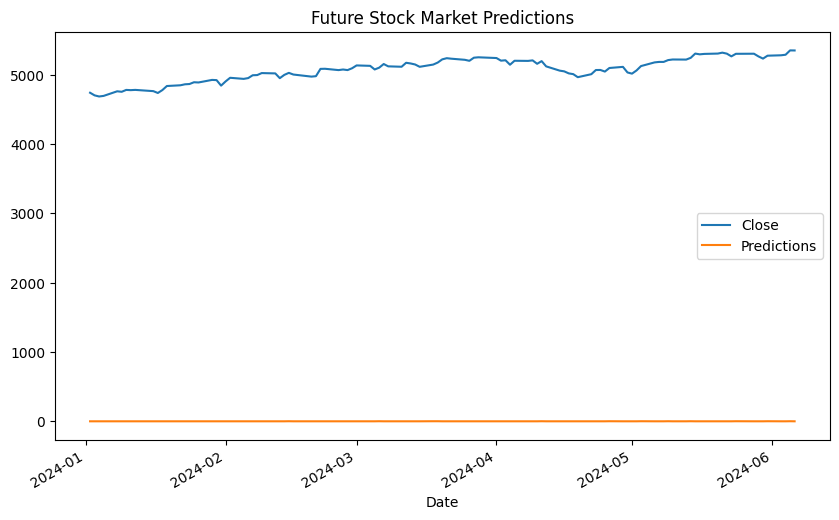

In [2]:
import yfinance as yf
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# Load or download data
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

# Ensure index is datetime
sp500.index = pd.to_datetime(sp500.index)

# Remove unwanted columns
sp500.drop(columns=["Dividends", "Stock Splits"], inplace=True)

# Create "Tomorrow" and "Target" columns
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

# Filter data from 2000-01-03
# sp500 = sp500.loc["2000-01-03":].copy()

# Create new predictors
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    new_predictors += [ratio_column, trend_column]

# Drop NaN values
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

# Retrain model with new predictors
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

# Backtest the model with new predictors
predictions = backtest(sp500, model, new_predictors)
print("New Prediction Value Counts:", predictions["Predictions"].value_counts())
print("New Precision Score:", precision_score(predictions["Target"], predictions["Predictions"]))
print("New Target Value Counts:", predictions["Target"].value_counts() / predictions.shape[0])

# Prepare future data for prediction
future_data = yf.Ticker("^GSPC").history(start="2024-01-01", end="2024-12-31")
future_data.index = pd.to_datetime(future_data.index)
future_data.drop(columns=["Dividends", "Stock Splits"], inplace=True)

# Calculate new predictors for future data
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    future_data[ratio_column] = future_data["Close"] / rolling_averages["Close"]
    trend_column = f"Trend_{horizon}"
    future_data[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

# Ensure no NaN values in the future data
future_data = future_data.dropna(subset=future_data.columns)

# Use the trained model to predict future values
future_predictions = model.predict_proba(future_data[new_predictors])[:, 1]
future_predictions[future_predictions >= 0.6] = 1
future_predictions[future_predictions < 0.6] = 0
future_predictions = pd.Series(future_predictions, index=future_data.index, name="Predictions")

# Combine future predictions with future data for analysis
combined_future = pd.concat([future_data["Close"], future_predictions], axis=1)
print(combined_future)

# Plot future predictions
combined_future.plot(y=["Close", "Predictions"], figsize=(10, 6), title="Future Stock Market Predictions")